# Imports and Data Information

In [1]:
# Regression
from statsmodels.formula.api import ols
from auxiliary_functions import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Data, maths, etc.
import numpy as np
import pandas as pd
# Plotting results
import matplotlib.pyplot as plt
import seaborn as sns
import forestplot as fp
# Formatting
from rich.console import Console
from rich.markdown import Markdown
console = Console()

## Dataset

In [2]:
ibm = pd.read_csv("data/enriched_datasets/ibm_all_features.csv", sep="\t")

As explained in the paper, the experiments are done with the average prediction probabilities of the _mixed-domain storytelling_ and _masked emotion_ classifiers. Due to the annotation process however, there are multiple further variants for these features. All possible feature variants are included in the dataset and are listed here to simplify future experiments. The table below gives an overview of annotation fields, including accumulated hyperclasses and modified features:

This results in the following features:

| **Variable/feature name** | **Feature**|
|---|---|
| - | text_id |
| `rank` | Data column containing the score between 0 and 1 of the dependent variable (DV) argument quality |
| `emotion_orig` | Binary aggregated emotion labels predicted with original training data, _anger\_orig, boredom\_orig, disgust\_orig, fear\_orig, guilt\_shame\_orig, joy\_orig, pride\_orig, relief\_orig, sadness\_orig, trust\_orig_ |
| `emotion_masked` | Binary aggregated emotion labels predicted with original training data, _anger\_masked, boredom\_masked, disgust\_masked, fear\_masked, guilt\_shame\_masked, joy\_masked, pride\_masked, relief\_masked, sadness\_masked, trust\_masked_ |
| `emotion_[masked/orig]_prob` | Output probabilities of the _masked/original_ classifier for emotion features |
| `negative_[masked/orig]` | Binary feature denoting the presence of any negative emotion aggregated from the classification results of _anger, boredom, disgust, fear, guilt/shame_ and _sadness_ of the corresponding classifier (`masked`, `orig`) |
| `positive_[masked/orig]` | Binary feature for the presence of any positive emotion aggregated from _joy, pride, relief, surprise, trust_ |
| `emotionality_[masked/orig]` | Sum of all predicted emotions for one training variant (`masked`, `orig`), the feature can adapt values [0;11] depending on how many of the eleven emotions were predicted for the instance |
| `hedging` | Absolute and relative hedge counts for the first, last and all sentences of an instance, _whole\_avg\_hedge, final\_abs\_hedge, final\_avg\_hedge, first\_abs\_hedge, first\_avg\_hedge, whole\_abs\_hedge_ |
| `storytelling` | Binary storytelling labels, _storytelling\_one\_domain, storytelling\_mixed\_domain_ |
| `storytelling_prob` | Prediction probabilities from storytelling classifiers, _prob\_storytelling\_mixed\_domain, prob\_storytelling\_one\_domain_ |

In [3]:
target_col = ['rank']

emotion_orig = [
    'anger_orig', 'boredom_orig', 
    'disgust_orig', 'fear_orig', 
    'guilt_shame_orig', 'joy_orig', 'pride_orig', 'relief_orig', 
    'sadness_orig',
    #'surprise_orig',
    'trust_orig', 
    'negative_orig', 'positive_orig'
]
emotion_orig_prob = [
    'prob_anger_orig', 'prob_boredom_orig', 'prob_disgust_orig', 
    'prob_fear_orig', 'prob_guilt_shame_orig', 'prob_joy_orig', 
    'prob_pride_orig', 'prob_relief_orig', 'prob_sadness_orig', 
    #'prob_surprise_orig', 
    'prob_trust_orig'
]

emotion_masked = [
    'anger_masked', 'boredom_masked', 'disgust_masked', 
    'fear_masked', 'guilt_shame_masked', 'joy_masked', 
    'pride_masked', 'relief_masked', 'sadness_masked', 
    #'surprise_masked', 
    'trust_masked', 'negative_masked', 'positive_masked'
]
emotion_masked_prob = [
    'prob_anger_masked', 'prob_boredom_masked', 
    'prob_disgust_masked', 
    'prob_fear_masked', 'prob_guilt_shame_masked', 'prob_joy_masked', 
    'prob_pride_masked', 'prob_relief_masked', 'prob_sadness_masked', 
    #'prob_surprise_masked', 
    'prob_trust_masked'
]

storytelling = ['storytelling_mixed_domain', 'storytelling_one_domain']
storytelling_prob = ['prob_storytelling_mixed_domain', 'prob_storytelling_one_domain']

hedging = ['first_abs_hedge', 'first_avg_hedge', 'final_abs_hedge', 'final_avg_hedge', 'whole_abs_hedge', 'whole_avg_hedge']

## Data distribution
Almost all features are very sparse, with _surprise_ removed from the analysis due to its complete absence from IBM ArgQ. Below are the number (#) and ratio (%) of the positive class for all binary features.

Data Distribution (binary labels)                                         

Overall number of instances: 5298                                                                                  

                               
  Feature           #       %  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  anger          1814   34.24  
  boredom         116    2.19  
  disgust        2920   55.12  
  fear            347    6.55  
  guilt/shame     107    2.02  
  joy              47    0.89  
  pride            80    1.51  
  relief           64    1.21  
  sadness         175    3.30  
  trust           112    2.11  
  negative       3473   65.55  
  positive        298    5.62  
  storytelling     45    0.85

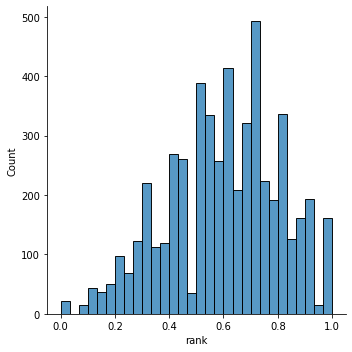

In [4]:
dist_cols = emotion_masked + ["storytelling_mixed_domain"]
l = len(ibm)
distribution = pd.DataFrame()
distribution["Feature"] = dist_cols
distribution["#"] = distribution.Feature.apply(lambda x: ibm[x].sum())
distribution["%"] = distribution["#"].apply(lambda x: 100*x/l)
distribution["Feature"] = distribution.Feature.apply(re_feats)
distribution.set_index("Feature", inplace=True)
console.print(Markdown(f"### Data Distribution (binary labels)\nOverall number of instances: {l}\n" +distribution.to_markdown(floatfmt=(".0f", ".0f", ".2f"))))
sns.displot(ibm, x="rank")

# 1 Individual Feature Regression
Each of the following models will have just one independent variable, sorted by variable type: 
1. Emotion
    - Output probability of masked classifier
2. Storytelling
    - Output probability of mixed domain classifier
3. Hedging
    - Bivariate/simple regression with all hedging variants
  
**NOTE:** p-Value significance levels are assumed at 0.05 (*), 0.01 (\*\*), 0.001 (\*\*\*)

## 1.1 Emotions
The feature variant used as IV here is the output probability of the classifier using training data with masked emotion words.

IV: Anger


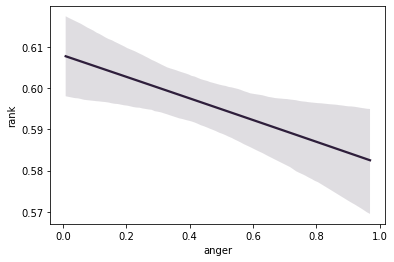

IV: Boredom


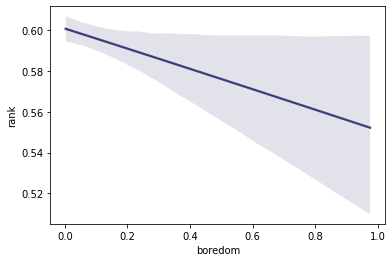

IV: Disgust


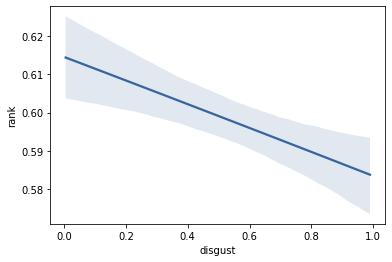

IV: Fear


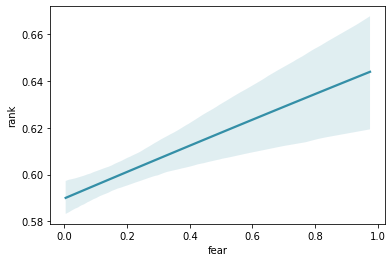

IV: Guilt/Shame


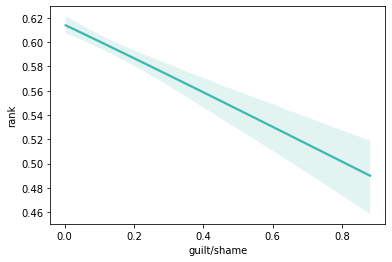

IV: Joy


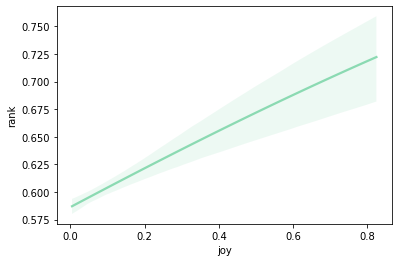

IV: Pride


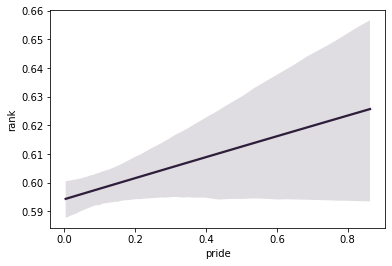

IV: Relief


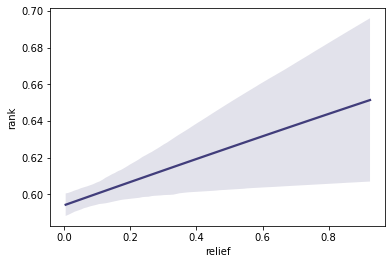

IV: Sadness


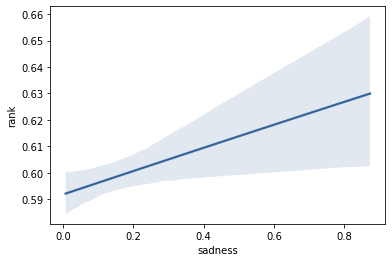

IV: Trust


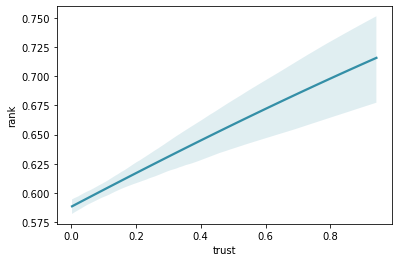

 Independent Variable     Coef   p-Value   adj. r2  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  anger                  0.9741    0.0086   0.00112  
  boredom                0.9515    0.0421   0.00059  
  disgust                0.9693    0.0004   0.00218  
  fear                   1.0573    0.0001   0.00261  
  guilt/shame            0.8702    0.0000   0.00971  
  joy                    1.1890    0.0000   0.00646  
  pride                  1.0373    0.0915   0.00035  
  relief                 1.0648    0.0226   0.00079  
  sadness                1.0450    0.0312   0.00069  
  trust                  1.1507    0.0000   0.00672

In [5]:
emotion_masked_prob

emotion_results = pd.DataFrame({
    "Independent Variable": ["/".join(emo.split("_")[1:-1]) for emo in emotion_masked_prob], 
    "Coef": [0]*len(emotion_masked_prob),
    "p-Value": [0]*len(emotion_masked_prob), 
    "adj. r2": [0]*len(emotion_masked_prob)
    }).set_index("Independent Variable")

for i, iv in enumerate(emotion_masked_prob):
    ibm_formula = f"rank ~ {iv}"
    emo = "/".join(iv.split("_")[1:-1])

    print("==============================================================================\nIV:", emo.title())
    results = ols(ibm_formula, ibm).fit()
    emotion_results.loc[emo,"adj. r2"] = results.rsquared_adj
    emotion_results.loc[emo,"p-Value"] = results.pvalues[iv]
    emotion_results.loc[emo,"Coef"] = np.exp(results.params[iv])
    plot_iv(ibm, iv, "rank", "ibm", (i%6, 6))

console.print(Markdown(emotion_results.to_markdown(floatfmt=(".0f", ".4f",".4f",".5f"))))

## 1.2 Storytelling
The feature variant used as IV here is the output probability of the classifier trained on mixed domain data.


IV: Storytelling


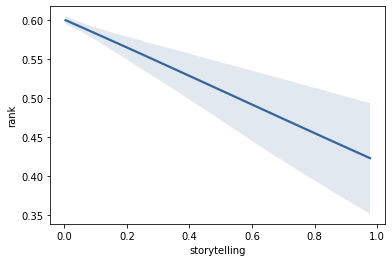

 Independent Variable      Coef   p-Value   adj. r2  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  storytelling           -0.1821    0.0000   0.00470

In [6]:
iv = "prob_storytelling_mixed_domain"
formula = f"rank ~ {iv}"

print("==============================================================================\nIV: Storytelling")
result = ols(formula, ibm).fit()
story_result = pd.DataFrame({
    "Independent Variable": "storytelling",
    "Coef": result.params[iv],
    "p-Value": result.pvalues[iv],
    "adj. r2": result.rsquared_adj
}, index=["storytelling"]).set_index("Independent Variable")

plot_iv(ibm, iv, "rank", "str", (2,6))

console.print(Markdown(story_result.to_markdown(floatfmt=(".0f", ".4f",".4f",".5f"))))

## 1.3 Hedging

The IVs used in the following models are the absolute count and ratio of hedge words for the first, last, and all sentences, with relative counts calculated through token ratio for sentences and sentence ratio for the whole instance:

| **Variable** | **Explanation** |
| -- | -- |
| `first_abs_hedge` | Number of hedge terms in the first sentence |
| `first_avg_hedge` | Ratio of hedge tokens in the first sentence |
| `final_abs_hedge` | Number of hedge terms in the final sentence |
| `final_avg_hedge` | Ratio of hedge tokens in the first sentence |
| `whole_abs_hedge` | Number of hedge terms in the instance |
| `whole_avg_hedge` | Ratio of hedge terms by sentence number in the instance |


IV: Hedging (First, Abs.)


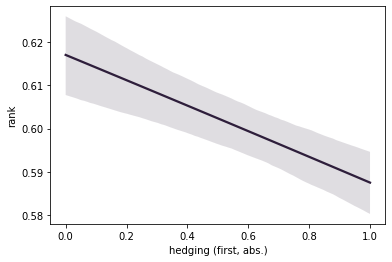


IV: Hedging (First, Avg.)


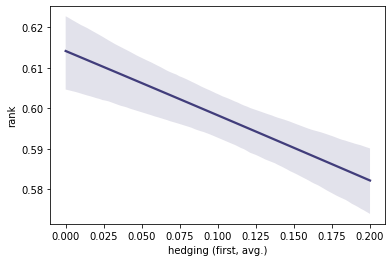


IV: Hedging (Final, Abs.)


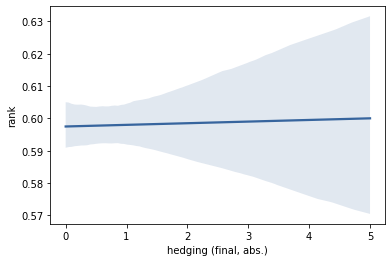


IV: Hedging (Final, Avg.)


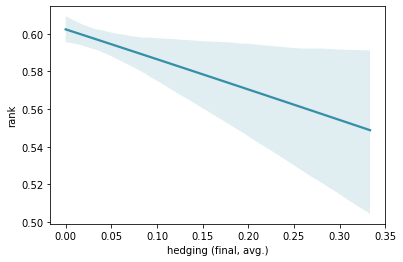


IV: Hedging (Whole, Abs.)


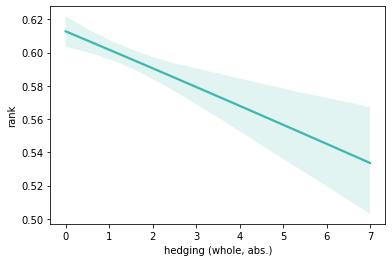


IV: Hedging (Whole, Avg.)


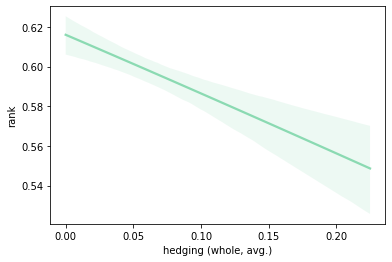

 Independent Variable      Coef   p-Value    adj. r2  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  hedging (first, abs.)   0.9709    0.0000    0.00443  
  hedging (first, avg.)   0.8524    0.0000    0.00359  
  hedging (final, abs.)   1.0005    0.8936   -0.00019  
  hedging (final, avg.)   0.8530    0.0264    0.00074  
  hedging (whole, abs.)   0.9889    0.0001    0.00271  
  hedging (whole, avg.)   0.7435    0.0000    0.00361

In [7]:
hedge_results = pd.DataFrame(
    {
        "Independent Variable": ["hedging (first, abs.)", "hedging (first, avg.)", 
                                 "hedging (final, abs.)", "hedging (final, avg.)", 
                                 "hedging (whole, abs.)", "hedging (whole, avg.)"],
        "Coef": [0]*6,
        "p-Value": [0]*6,
        "adj. r2": [0]*6
    }
).set_index("Independent Variable")
for i, iv in enumerate(hedging):
    formula = f"rank ~ {iv}"
    h = iv.split("_")
    hedge = f"hedging ({h[0]}, {h[1]}.)"
    print("\n==============================================================================\nIV:", hedge.title())
    result = ols(formula, ibm).fit()
    hedge_results.loc[hedge,"adj. r2"] = result.rsquared_adj
    hedge_results.loc[hedge,"p-Value"] = result.pvalues[iv]
    hedge_results.loc[hedge,"Coef"] = np.exp(result.params[iv])
    plot_iv(ibm, iv, "rank", "ibm", (i,6))

console.print(Markdown(hedge_results.to_markdown(floatfmt=(".0f", ".4f",".4f",".5f"))))

# 2 Multilinear Regression with all Features

Robust regression relies on independent variables that are not themselves correlated. Thus, for the full regression analysis without interaction, we first check for multicolinearity between all variables. To that end, we calculate the variance inflation factor between groups of two and three variables, which indicates the increased standard error of a multicolinear predictor in comparison to a non-correlated predictor (cf. Johnston et al., 2018).

In [8]:
features = ["prob_storytelling_mixed_domain", "whole_abs_hedge"] + emotion_masked_prob
h = ibm[features]
vif_data = pd.DataFrame() 
vif_data["Feature"] = h.columns 
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
vif_data["Feature"] = vif_data["Feature"].apply(re_feats)
console.print(Markdown("**Variance Inflation Factor**\n" + vif_data.to_markdown(index=False, floatfmt=".3f")))
console.print(Markdown("The highest VIF values occur in _anger_ and _disgust_, which are also the most frequent features. " \
"As the performance of _digust_ is higher than that of _anger_ on the held-out test set of the training data, " \
"we remove the latter variable from the full analyses for more robust regression results."))

features.pop(2)
h = ibm[features]
vif_data = pd.DataFrame() 
vif_data["Feature"] = h.columns 
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
vif_data["Feature"] = vif_data["Feature"].apply(re_feats)
console.print(Markdown("**Variance Inflation Factor without _anger_**\n" + vif_data.to_markdown(index=False, floatfmt=".3f")))

Variance Inflation Factor                                                                                          

                                 
  Feature                   VIF  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  storytelling            1.059  
  hedging (whole, abs.)   3.114  
  anger                   4.842  
  boredom                 1.339  
  disgust                 5.677  
  fear                    1.775  
  guilt/shame             2.410  
  joy                     2.252  
  pride                   2.539  
  relief                  1.386  
  sadness                 2.436  
  trust                   1.432

The highest VIF values occur in anger and disgust, which are also the most frequent features. As the performance of
digust is higher than that of anger on the held-out test set of the training data, we remove the latter variable   
from the full analyses for more robust regression results.

Variance Inflation Factor without anger                                                                            

                                 
  Feature                   VIF  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  storytelling            1.059  
  hedging (whole, abs.)   3.106  
  boredom                 1.271  
  disgust                 3.405  
  fear                    1.609  
  guilt/shame             2.404  
  joy                     2.247  
  pride                   2.500  
  relief                  1.377  
  sadness                 2.408  
  trust                   1.396

1 remaining variable that was not chosen: boredom

 Independent Variables        Coef   p-Value   Significance             adj. r2  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  guilt/shame               -0.1311    0.0000   x                        0.00971  
  + storytelling            -0.2082    0.0000   7.748539729328379e-08    0.01491  
  + sadness                  0.1297    0.0000   3.068058060395711e-06    0.01876  
  + trust                    0.1900    0.0000   6.3733905311821645e-09   0.02481  
  + joy                      0.2992    0.0000   1.2573942138765845e-07   0.02976  
  + fear                     0.1064    0.0000   8.956221218605605e-09    0.03562  
  + disgust                  0.0477    0.0001   0.00011188582838163736   0.03816  
  + hedging (whole, abs.)   -0.0091    0.0026   0.003413307832809299     0.03954  
  + relief                   0.0752    0.0086   0.012843959071271532     0.04048  
  + pride                   -0.0543    0.0499   0.049894777023325704     0.04099

Full Model Results The table lists all independent variables of the full model without interaction after the       
stepwise selection process. Thus, variables are ordered from first to last selected, with the Coefficient and      
p-Value refering to the respective values of the individual IV in the full final model, while the Significance and 
adjusted r2 refer to the model containing all IVs up to the current one. Significance is calculated via ANOVA      
comparing to the next smaller model, and thus not calculated for the first selected IV.

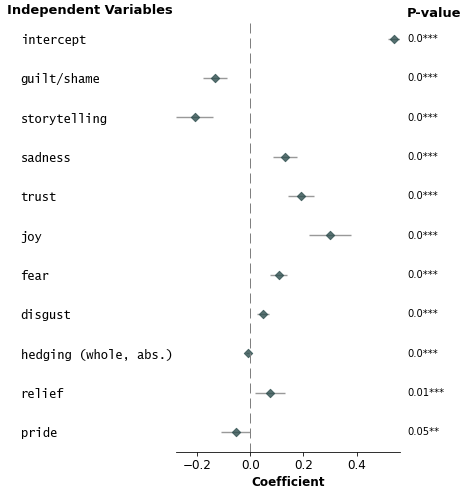

In [9]:
features = ["rank", "prob_storytelling_mixed_domain", "whole_abs_hedge"] + emotion_masked_prob[1:]

data = ibm[features]
# Using forward selection function to calculate best features
full_multi_result = forward_selection(data, "rank", "ols")
full_multi_model = full_multi_result["model"]
full_multi_remaining = full_multi_result["remaining"]
full_multi_sign = full_multi_result["significance"]
full_multi_r2 = full_multi_result["r2"]
full_multi_coef = full_multi_result["params"]

if not len(full_multi_remaining):
    console.print("No remaining variables that were not chosen.")
else:
    console.print(Markdown(f"{len(full_multi_remaining)} remaining variable that was not chosen:\n{', '.join(map(re_feats, full_multi_remaining))}"))

names = list(map(re_feats,full_multi_model.params.index[1:]))
r_list = pd.DataFrame({
    "Independent Variables": ["+ "+names[i] if i else names[i] for i in range(len(names))],
    "Coef": full_multi_coef["coef"],
    "p-Value": full_multi_coef["p-Value"],
    "Significance": full_multi_sign,
    "adj. r2": full_multi_r2
    }).set_index("Independent Variables")

console.print(Markdown(r_list.to_markdown(floatfmt=(".0f", ".4f",".4f",".4f",".5f"))))
console.print(Markdown("**Full Model Results**\nThe table lists all independent variables of the full model without interaction after the stepwise selection process. " \
"Thus, variables are ordered from first to last selected, with the Coefficient and p-Value refering to the respective values of the individual IV in the full final model, " \
"while the Significance and adjusted r2 refer to the model containing all IVs up to the current one. Significance is calculated via ANOVA comparing to the next smaller model, "
"and thus not calculated for the first selected IV."))

params = full_multi_model.params
conf = full_multi_model.conf_int()
conf['Coefficient'] = full_multi_model.params
conf.columns = ['5%', '95%', 'Effect']
conf["Variables"] = ["intercept"] + [re_feats(x) for x in list(params.index)[1:]]
conf["p-Value"] = full_multi_model.pvalues

fp.forestplot(conf,  # the dataframe with results data
              estimate="Effect",  # Estimated effect size 
              ll="5%", hl="95%",  # Confidence interval limits
              varlabel="Variables",  # Variable label
              ylabel="Independent Variables",
              xlabel="Coefficient",
              pval="p-Value",
              ci_report=False,  # Turn off conf. int. reporting
              # Additional kwargs for customizations
              **{"marker": "D",  # Set maker symbol as diamond
                 "markersize": 35,  # Adjust marker size
                 "xlinestyle": (1, (10, 5)),  # Long dash for x-reference line 
                 "xlinecolor": "#808080",  # Gray color for x-reference line
                 "xtick_size": 12,  # Adjust x-ticker fontsize
                #  'fontfamily': 'serif'  # revert to sans-serif
                } 
              )

plt.savefig("img/ibm_multilinear_forestplot.svg", bbox_inches="tight", format="svg")

# 3 Analysis with All Variables and 2-way Interaction

 Independent Variables                       Coef   p-Value   Significance             adj. r2  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  guilt/shame                              -0.1284    0.0000   x                        0.00971  
  + storytelling : hedging (whole, abs.)   -0.1751    0.0000   1.269775886779374e-10    0.01723  
  + fear : guilt/shame                      0.1187    0.2587   2.9336711455303043e-08   0.02273  
  + trust                                   0.3390    0.0000   3.688963338159795e-07    0.02731  
  + disgust : sadness                       0.0678    0.2459   2.2568602523802977e-07   0.03204  
  + joy                                     0.1924    0.0000   1.7440695795504972e-07   0.03684  
  + boredom : trust                        -4.0699    0.0000   2.8750493434498477e-06   0.04064  
  + pride : sadness                        -0.9243    0.0025   0.00017153720607624673   0.04302  
  + joy : relief                            0.6789    0.0034   0.007000836837836562     0.04415  
  + disgust : fear                          0.1259    0.0005   0.008101940861388667     0.04524  
  + sadness                                 0.1214    0.0037   0.0025792869798845807    0.04670  
  + storytelling : trust                   -0.4162    0.0100   0.02097627320159828      0.04748  
  + guilt/shame : trust                    -0.8056    0.0164   0.03742481892928911      0.04808  
  + pride : trust                          -0.4070    0.0179   0.017871568148477776     0.04891

Full Model Results The table lists all independent variables of the full model with 2-way interaction after the    
stepwise selection process. Thus, variables are ordered from first to last selected, with the Coefficient and      
p-Value refering to the respective values of the individual IV in the full final model, while the Significance and 
adjusted r2 refer to the model containing all IVs up to the current one. Significance is calculated via ANOVA      
comparing to the next smaller model, and thus not calculated for the first selected IV.

7 remaining variables and 100 interactions were not chosen.

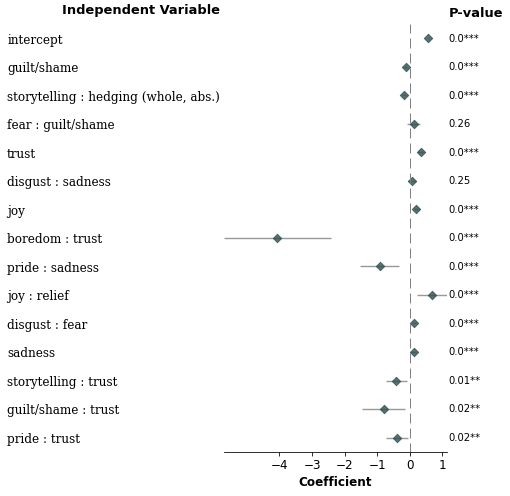

In [10]:
# Using forward selection function to calculate best features based on AIC 
# and stop selection based on missing significance of model improvement (ANOVA)
full_result = poly_forward_selection(ibm[features], 'rank', "ols")
full_model = full_result["model"]
full_remaining = full_result["remaining"]
full_sign = full_result["significance"]
full_r2 = full_result["r2"]
full_coef = full_result["params"]["coef"]
full_p = full_result["params"]["p-Value"]

names = list(map(re_feats,full_model.params.index[1:]))
r_list = pd.DataFrame({
    "Independent Variables": ["+ "+names[i] if i else names[i] for i in range(len(names))],
    "Coef": full_coef,
    "p-Value": full_p,
    "Significance": full_sign,
    "adj. r2": full_r2
}).set_index("Independent Variables")

console.print(Markdown(r_list.to_markdown(floatfmt=(".0f", ".4f",".4f",".4f",".5f"))))
console.print(Markdown("**Full Model Results**\nThe table lists all independent variables of the full model with 2-way interaction after the stepwise selection process. " \
"Thus, variables are ordered from first to last selected, with the Coefficient and p-Value refering to the respective values of the individual IV in the full final model, " \
"while the Significance and adjusted r2 refer to the model containing all IVs up to the current one. Significance is calculated via ANOVA comparing to the next smaller model, "
"and thus not calculated for the first selected IV."))

full_params = full_model.params
full_conf = full_model.conf_int()
full_conf['Coefficient'] = full_model.params
full_conf.columns = ['5%', '95%', 'Effect']
full_conf["Variables"] = ["intercept"] + [re_feats(x) for x in list(full_params.index)[1:]]
full_conf["p-Value"] = full_model.pvalues

fp.forestplot(full_conf,
              estimate="Effect",
              ll="5%", hl="95%",
              varlabel="Variables",
              ylabel="Independent Variable",
              xlabel="Coefficient",
              pval="p-Value",
              ci_report=False,  # Turn off conf. int. reporting
              xticks=[-4,-3,-2,-1,0,1],  # x-ticks to be printed
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (1, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                 'fontfamily': 'serif'  # revert to sans-serif
                } 
              )
plt.savefig("img/ibm_poly_forestplot.svg", bbox_inches="tight", format="svg")

if not len(full_remaining):
    console.print("No remaining variables that were not chosen.")
else:
    inter = len([x for x in full_remaining if ":" in x])
    console.print(Markdown(f"{len(full_remaining)-inter} remaining variables and {inter} interactions were not chosen."))

# References

- Ron Johnston, Kelvyn Jones, and David Manley. 2018. [Confounding and collinearity in regression analysis: a cautionary tale and an alternative procedure, illustrated by studies of British voting behaviour](https://link.springer.com/article/10.1007/s11135-017-0584-6). _Qual Quant_ 52 (1957-1976).